In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd #  processing, CSV file I/O (e.g. pd.read_csv)
!pip install cdlib
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.3/230.3 kB 3.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 35.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: igraph
    Found existing installation: igraph 0.10.6
    Uninstalling igraph-0.10.6:
      Successfully uninstalled igraph-0.10.6
/kaggle/input/fronto-parietal-fmri-timeseries/frontoparietal_ts/healthy/sub_allnetworksnew-40.csv
/kaggle/input/fronto-parietal-fmri-timeseries/frontoparietal_ts/healthy/sub_allnetworksnew-35.csv
/kaggle/input/fronto-parietal-fmri-timeseries/frontoparietal_ts/healthy/sub_allnetworksnew-19.csv
/kaggle/input/fronto-parietal-fmri-timeseries/frontoparietal_ts/healthy/sub_allnetworksnew-18.csv
/kaggle/input/fronto-parietal-fmri-timeseries/frontoparietal_ts/healthy/sub_allnetworksnew-20.csv
/kaggle/input/fronto-parietal-fmri-timeseries/frontoparietal_ts/healthy/sub_allnetworksnew-37.csv
/kaggle/input/fronto-parietal-fmri-timeseries/frontoparietal_ts/healthy/sub_al

In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.9 MB/s eta 0:00:0000:010:01


# Graph Creation

In [3]:
import torch
import torch_geometric
from torch_geometric.data import InMemoryDataset, Data
import networkx as nx
import numpy as np
import os
import pandas as pd
from scipy.linalg import pinv
from sklearn.model_selection import train_test_split

# Define the directory where your CSV files are located
data_directory = '/kaggle/input/fmri-timeseries-csvdata/to_send/Combined'  # Adjust this path

# Threshold for partial correlations (adjust as needed)
threshold = 0.0  # For example, you can use 0.3 as a threshold

# Define a custom PyTorch Geometric dataset class
class MyGraphDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(MyGraphDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ['graph_data.pt']

    def download(self):
        pass

    def process(self):
        data_list = []

        for subject_id in range(1, 101):
            csv_file = os.path.join(data_directory, f'new_sub-{subject_id}.csv')
            column_names = [f'TimeStamp_{i}' for i in range(1, 188)]  # 327 timestamps
            df = pd.read_csv(csv_file, names=column_names)

            # Calculate the precision matrix (inverse of the covariance matrix) using all timestamps
            cov_matrix = np.cov(df.T)
            precision_matrix = pinv(cov_matrix)

            # Create an empty graph for the current subject
            G = nx.Graph()

            # Add nodes with sizes based on the values in the CSV
            for region in range(34):
                size = np.mean(df.iloc[region])*1000  # Adjust the scaling factor and offset as needed
                G.add_node(region, size=size)

            # Add edges between nodes based on the thresholded partial correlations
            edge_index = []
            edge_weights = []  # List to store edge weights

            for i in range(34):
                for j in range(i + 1, 34):
                    if i != j:
                        partial_corr = -precision_matrix[i, j] / np.sqrt(precision_matrix[i, i] * precision_matrix[j, j])
                        if partial_corr >= threshold:
                            G.add_edge(i, j)
                            edge_index.append((i, j))
                            edge_weights.append(partial_corr)  # Add edge weight based on partial correlation
            # Calculate the degree of each node
            for node in G.nodes:
                degree = G.degree(node)
                G.nodes[node]['degree'] = degree  # Add the degree as an additional feature
                
            # Convert the graph to a PyTorch Geometric Data object
            x = torch.tensor([G.nodes[node]['size'] for node in G.nodes()], dtype=torch.float32).unsqueeze(1)
            degree_feature = torch.tensor([G.nodes[node]['degree'] for node in G.nodes()], dtype=torch.float32).unsqueeze(1)
            x = torch.cat((x, degree_feature), dim=1)
            y = torch.tensor([subject_id <= 50], dtype=torch.long)  # Binary classification (healthy vs. MCI)
            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
            edge_attr = torch.tensor(edge_weights, dtype=torch.float32)  # Store edge weights as edge attributes

            data_obj = Data(x=x, edge_index=edge_index, y=y, edge_attr=edge_attr)  # Include edge attributes
            data_list.append(data_obj)

        # Save the dataset
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

# Create and load the custom dataset
dataset = MyGraphDataset(root='./data8')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.4f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...



Dataset: MyGraphDataset(100):
Number of graphs: 100
Number of features: 2
Number of classes: 2

Data(x=[34, 2], edge_index=[2, 286], edge_attr=[286], y=[1])
Number of nodes: 34
Number of edges: 286
Average node degree: 8.4118
Has isolated nodes: False
Has self-loops: False
Is undirected: False


Done!


In [4]:
# Specify the index of the sample you want to view (e.g., 0 for the first sample)
sample_index = 0

# Get the sample from the dataset
sample = dataset[sample_index]

# Extract the relevant information from the sample
x = sample.x  # Node features (sizes)
edge_index = sample.edge_index  # Edge indices
edge_attr = sample.edge_attr  # Edge attributes (weights)
y = sample.y  # Label (0 for healthy, 1 for MCI)

# Display the extracted information
print(f'Sample Index: {sample_index}')
print(f'Node Features (Sizes): {x}')
print(f'Edge Indices: {edge_index}')
print(f'Edge Attributes (Weights): {edge_attr}')
print(f'Label (0 for Healthy, 1 for MCI): {y}')

Sample Index: 0
Node Features (Sizes): tensor([[  5.3527,  21.0000],
        [-12.0722,  17.0000],
        [-32.1503,  20.0000],
        [ -3.3294,  21.0000],
        [-56.6299,  16.0000],
        [  2.0807,  14.0000],
        [ -2.9352,  15.0000],
        [  3.7323,  18.0000],
        [ 12.5033,  21.0000],
        [ -5.0059,  17.0000],
        [ -6.7290,  14.0000],
        [-31.9629,  17.0000],
        [-12.6889,  20.0000],
        [ -2.4051,  17.0000],
        [  9.6806,  18.0000],
        [  0.5241,  10.0000],
        [ -2.4165,  19.0000],
        [  1.0602,  20.0000],
        [ -0.7549,  16.0000],
        [ -0.9722,  15.0000],
        [ -2.1233,  14.0000],
        [ -4.0967,  20.0000],
        [  3.3621,  16.0000],
        [ -4.0260,  18.0000],
        [  2.3573,  17.0000],
        [ -6.0854,  13.0000],
        [ 19.4896,  20.0000],
        [ -5.4830,  18.0000],
        [-21.0214,  17.0000],
        [  5.1509,  13.0000],
        [ -0.9219,  12.0000],
        [ -6.5074,  18.0000],
 

## SIngle Graph Sub-community detection

In [5]:
import networkx as nx
from networkx.algorithms.community import k_clique_communities

# Load the graph from the PyTorch Geometric dataset
data = dataset[0]

# Extract the edge information and labels from the PyTorch Geometric Data object
edge_index = data.edge_index
labels = data.y

# Convert the edge information to a NetworkX graph
graph = nx.Graph()
graph.add_nodes_from(range(data.num_nodes))
edges = edge_index.t().tolist()
graph.add_edges_from(edges)

# Function to find all subcommunities, the largest community, and nodes not in any community
def find_all_community_info(graph, k):
    # Find k-clique communities
    cliques = list(k_clique_communities(graph, k))
    
    # Convert communities to a list of lists for easier access
    subcommunities = [list(community) for community in cliques]
    
    # Find nodes that are not part of any community
    all_nodes = set(graph.nodes())
    nodes_in_communities = set(node for community in subcommunities for node in community)
    nodes_not_in_communities = all_nodes - nodes_in_communities

    # Find the largest community
    largest_community = max(subcommunities, key=len, default=set())

    return subcommunities, largest_community, list(nodes_not_in_communities)

# Define the desired 'k' value for clique communities
k_value =5  # You can change this value as needed

# Find all subcommunities, the largest community, and nodes not in any community
all_subcommunities, largest_community, nodes_not_in_communities = find_all_community_info(graph, k_value)

# Print all subcommunities
print("All Subcommunities:")
for i, subcommunity in enumerate(all_subcommunities):
    print(f"Subcommunity {i + 1}: {subcommunity}")

# Print the largest community
print("\nLargest Community:")
print(largest_community)

# Print nodes not in any community
print("\nNodes Not in Any Community:")
print(nodes_not_in_communities)

All Subcommunities:
Subcommunity 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 20, 22, 23, 24, 26, 28, 29, 30, 31, 32, 33]
Subcommunity 2: [17, 19, 26, 27, 30]

Largest Community:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 20, 22, 23, 24, 26, 28, 29, 30, 31, 32, 33]

Nodes Not in Any Community:
[25, 21, 15]


# Sub-Communities for All Graphs

# Clique Percolation

In [6]:
import networkx as nx
from networkx.algorithms.community import k_clique_communities

# Function to find all community info for a given graph
def find_all_community_info(graph, k):
    # Find k-clique communities
    cliques = list(k_clique_communities(graph, k))
    
    # Convert communities to a list of lists for easier access
    subcommunities = [list(community) for community in cliques]
    
    # Find nodes that are not part of any community
    all_nodes = set(graph.nodes())
    nodes_in_communities = set(node for community in subcommunities for node in community)
    nodes_not_in_communities = all_nodes - nodes_in_communities

    # Find the largest community
    largest_community = max(subcommunities, key=len, default=set())

    return subcommunities, largest_community, list(nodes_not_in_communities)

# Define the desired 'k' value for clique communities
k_value =5   # You can change this value as needed

# Loop through each graph in the dataset
for idx, data in enumerate(dataset):
    print(f"Graph {idx + 1}:")
    
    # Extract the edge information and labels from the PyTorch Geometric Data object
    edge_index = data.edge_index

    # Convert the edge information to a NetworkX graph
    graph = nx.Graph()
    graph.add_nodes_from(range(data.num_nodes))
    edges = edge_index.t().tolist()
    graph.add_edges_from(edges)

    # Find all subcommunities, the largest community, and nodes not in any community
    all_subcommunities, largest_community, nodes_not_in_communities = find_all_community_info(graph, k_value)

    # Print all subcommunities
    print("All Subcommunities:")
    for i, subcommunity in enumerate(all_subcommunities):
        print(f"Subcommunity {i + 1}: {subcommunity}")

    # Print the largest community
    print("\nLargest Community:")
    print(largest_community)
    print("\nLargest Community Size:")
    print(len(largest_community))

    # Print nodes not in any community
    print("\nNodes Not in Any Community:")
    print(nodes_not_in_communities)
    print("\n")

Graph 1:
All Subcommunities:
Subcommunity 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 20, 22, 23, 24, 26, 28, 29, 30, 31, 32, 33]
Subcommunity 2: [17, 19, 26, 27, 30]

Largest Community:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 20, 22, 23, 24, 26, 28, 29, 30, 31, 32, 33]

Largest Community Size:
29

Nodes Not in Any Community:
[25, 21, 15]


Graph 2:
All Subcommunities:
Subcommunity 1: [16, 17, 2, 6, 8]
Subcommunity 2: [0, 5, 6, 7, 8, 9, 12, 14, 15, 16, 17, 19, 20, 21, 22, 25, 26, 27, 28, 30, 31, 32, 33]
Subcommunity 3: [6, 8, 21, 23, 24, 30]
Subcommunity 4: [11, 24, 26, 27, 30, 31]

Largest Community:
[0, 5, 6, 7, 8, 9, 12, 14, 15, 16, 17, 19, 20, 21, 22, 25, 26, 27, 28, 30, 31, 32, 33]

Largest Community Size:
23

Nodes Not in Any Community:
[1, 3, 4, 10, 13, 18, 29]


Graph 3:
All Subcommunities:
Subcommunity 1: [32, 10, 11, 12, 16, 17, 21, 26, 29]
Subcommunity 2: [1, 5, 6, 9, 14, 22, 25]
Subcommunity 3: [0, 1, 3, 4, 5, 6, 8, 11, 12, 14, 1

In [7]:
import networkx as nx
from networkx.algorithms.community import k_clique_communities
from collections import Counter

# Define the desired 'k' value for clique communities
k_value =5   # You can change this value as needed

# Initialize dictionaries to store node counts for healthy and MCI subjects
healthy_node_counts = Counter()
mci_node_counts = Counter()

# Loop through each graph in the dataset
for idx, data in enumerate(dataset):
    # Extract the edge information and labels from the PyTorch Geometric Data object
    edge_index = data.edge_index
    labels = data.y

    # Convert the edge information to a NetworkX graph
    graph = nx.Graph()
    graph.add_nodes_from(range(data.num_nodes))
    edges = edge_index.t().tolist()
    graph.add_edges_from(edges)

    # Find the largest community in the graph
    largest_community = max(k_clique_communities(graph, k_value), key=len, default=set())

    # Increment the node counts based on labels (healthy or MCI)
    nodes_in_largest_community = list(largest_community)
    label = "Healthy" if labels == 1 else "MCI"

    if label == "Healthy":
        healthy_node_counts.update(nodes_in_largest_community)
    elif label == "MCI":
        mci_node_counts.update(nodes_in_largest_community)

# Find the most occurring nodes for healthy and MCI subjects
most_occuring_healthy_nodes = healthy_node_counts.most_common(10)
most_occuring_mci_nodes = mci_node_counts.most_common(10)

print("Most Occurring Nodes in the Largest Subcommunity for Healthy Subjects:")
for node, count in most_occuring_healthy_nodes:
    print(f"Node {node}: Occurs in {count} graphs")

print("\nMost Occurring Nodes in the Largest Subcommunity for MCI Subjects:")
for node, count in most_occuring_mci_nodes:
    print(f"Node {node}: Occurs in {count} graphs")

Most Occurring Nodes in the Largest Subcommunity for Healthy Subjects:
Node 5: Occurs in 39 graphs
Node 14: Occurs in 37 graphs
Node 0: Occurs in 36 graphs
Node 11: Occurs in 35 graphs
Node 12: Occurs in 35 graphs
Node 17: Occurs in 35 graphs
Node 18: Occurs in 35 graphs
Node 22: Occurs in 35 graphs
Node 1: Occurs in 34 graphs
Node 2: Occurs in 34 graphs

Most Occurring Nodes in the Largest Subcommunity for MCI Subjects:
Node 20: Occurs in 38 graphs
Node 33: Occurs in 36 graphs
Node 16: Occurs in 36 graphs
Node 31: Occurs in 35 graphs
Node 1: Occurs in 35 graphs
Node 30: Occurs in 35 graphs
Node 0: Occurs in 34 graphs
Node 5: Occurs in 34 graphs
Node 6: Occurs in 34 graphs
Node 15: Occurs in 34 graphs


In [8]:
most_occuring_healthy_nodes = healthy_node_counts.most_common(34)
least_occuring_healthy_nodes = healthy_node_counts.most_common(34)  # Get the bottom 10
most_occuring_mci_nodes = mci_node_counts.most_common(34)
least_occuring_mci_nodes = mci_node_counts.most_common(34)  # Get the bottom 10

print("Most Occurring Nodes in the Largest Subcommunity for Healthy Subjects:")
for node, count in most_occuring_healthy_nodes:
    print(f"Node {node}: Occurs in {count} graphs")

print("\nLeast Occurring Nodes in the Largest Subcommunity for Healthy Subjects:")
for node, count in least_occuring_healthy_nodes:
    print(f"Node {node}: Occurs in {count} graphs")

print("\nMost Occurring Nodes in the Largest Subcommunity for MCI Subjects:")
for node, count in most_occuring_mci_nodes:
    print(f"Node {node}: Occurs in {count} graphs")

print("\nLeast Occurring Nodes in the Largest Subcommunity for MCI Subjects:")
for node, count in least_occuring_mci_nodes:
    print(f"Node {node}: Occurs in {count} graphs")

Most Occurring Nodes in the Largest Subcommunity for Healthy Subjects:
Node 5: Occurs in 39 graphs
Node 14: Occurs in 37 graphs
Node 0: Occurs in 36 graphs
Node 11: Occurs in 35 graphs
Node 12: Occurs in 35 graphs
Node 17: Occurs in 35 graphs
Node 18: Occurs in 35 graphs
Node 22: Occurs in 35 graphs
Node 1: Occurs in 34 graphs
Node 2: Occurs in 34 graphs
Node 16: Occurs in 34 graphs
Node 6: Occurs in 33 graphs
Node 26: Occurs in 33 graphs
Node 3: Occurs in 32 graphs
Node 8: Occurs in 31 graphs
Node 20: Occurs in 31 graphs
Node 28: Occurs in 31 graphs
Node 30: Occurs in 31 graphs
Node 31: Occurs in 31 graphs
Node 33: Occurs in 31 graphs
Node 19: Occurs in 31 graphs
Node 25: Occurs in 31 graphs
Node 4: Occurs in 30 graphs
Node 9: Occurs in 30 graphs
Node 15: Occurs in 30 graphs
Node 21: Occurs in 30 graphs
Node 13: Occurs in 29 graphs
Node 23: Occurs in 29 graphs
Node 24: Occurs in 29 graphs
Node 29: Occurs in 29 graphs
Node 7: Occurs in 28 graphs
Node 32: Occurs in 27 graphs
Node 10: Oc

In [9]:
sum(largest_community)/len(largest_community)

16.5

In [10]:
import networkx as nx
from networkx.algorithms.community import k_clique_communities
from collections import Counter
import pandas as pd

# Define the desired 'k' value for clique communities
k_value =5  # You can change this value as needed

# Initialize dictionaries to store node counts for healthy and MCI subjects
healthy_node_counts = Counter()
mci_node_counts = Counter()

# Loop through each graph in the dataset
for idx, data in enumerate(dataset):
    # Extract the edge information and labels from the PyTorch Geometric Data object
    edge_index = data.edge_index
    labels = data.y

    # Convert the edge information to a NetworkX graph
    graph = nx.Graph()
    graph.add_nodes_from(range(data.num_nodes))
    edges = edge_index.t().tolist()
    graph.add_edges_from(edges)

    # Find the largest community in the graph
    largest_community = max(k_clique_communities(graph, k_value), key=len, default=set())

    # Increment the node counts based on labels (healthy or MCI)
    nodes_in_largest_community = list(largest_community)
    label = "Healthy" if labels == 1 else "MCI"

    if label == "Healthy":
        healthy_node_counts.update(nodes_in_largest_community)
    elif label == "MCI":
        mci_node_counts.update(nodes_in_largest_community)

# Find the most occurring nodes for healthy and MCI subjects
most_occuring_healthy_nodes = healthy_node_counts.most_common(34)
most_occuring_mci_nodes = mci_node_counts.most_common(34)

# Create DataFrames for most occurring nodes
df_most_occuring_healthy = pd.DataFrame(most_occuring_healthy_nodes, columns=["Node", "Count (Healthy)"])
df_most_occuring_mci = pd.DataFrame(most_occuring_mci_nodes, columns=["Node", "Count (MCI)"])

# # Display the DataFrames
# print("Most Occurring Nodes in the Largest Subcommunity for Healthy Subjects:")
(df_most_occuring_healthy)



,Node,Count (Healthy)
0,5,39
1,14,37
2,0,36
3,11,35
4,12,35
5,17,35
6,18,35
7,22,35
8,1,34
9,2,34


In [11]:
# Sort the DataFrames by the "Node" column
Nodeord_df_most_occuring_healthy = df_most_occuring_healthy.sort_values(by="Node")
Nodeord_df_most_occuring_mci = df_most_occuring_mci.sort_values(by="Node")

# Display the sorted DataFrames
(Nodeord_df_most_occuring_healthy).to_csv("Nodeord_df_most_occuring_healthy.csv", index=False)
(Nodeord_df_most_occuring_mci).to_csv("Nodeord_df_most_occuring_mci.csv", index=False)

In [12]:
# print("\nMost Occurring Nodes in the Largest Subcommunity for MCI Subjects:")
# (df_most_occuring_mci)

In [13]:
df_most_occuring_healthy.to_csv("CPM_most_occuring_healthy_nodes.csv", index=False)
df_most_occuring_mci.to_csv("CPM_most_occuring_mci_nodes.csv", index=False)

In [14]:
# import networkx as nx
# import community  # Louvain community detection library

# # Function to find all community info for a given graph using the Louvain algorithm
# def find_all_community_info_louvain(graph):
#     # Find communities using the Louvain algorithm
#     louvain_partition = community.best_partition(graph)

#     # Convert the Louvain partition into a dictionary of communities
#     louvain_communities = {}
#     for node, community_id in louvain_partition.items():
#         if community_id not in louvain_communities:
#             louvain_communities[community_id] = [node]
#         else:
#             louvain_communities[community_id].append(node)

#     # Find the largest community
#     louvain_largest_community = max(louvain_communities.values(), key=len)

#     return list(louvain_communities.values()), louvain_largest_community

# # Loop through each graph in the dataset
# for idx, data in enumerate(dataset):
#     print(f"Graph {idx + 1}:")

#     # Convert the edge information to a NetworkX graph
#     louvain_graph = nx.Graph()
#     louvain_graph.add_nodes_from(range(data.num_nodes))
#     edges = data.edge_index.t().tolist()
#     louvain_graph.add_edges_from(edges)

#     # Find all communities and the largest community using the Louvain algorithm
#     all_louvain_communities, louvain_largest_community = find_all_community_info_louvain(louvain_graph)

#     # Print all communities
#     print("All Louvain Communities:")
#     for i, louvain_community_nodes in enumerate(all_louvain_communities):
#         print(f"Louvain Community {i + 1}: {louvain_community_nodes}")

#     # Print the largest Louvain community
#     print("\nLargest Louvain Community:")
#     print(louvain_largest_community)
#     print("\nLargest Louvain Community Size:")
#     print(len(louvain_largest_community))
#     print("\n")


In [15]:
# import networkx as nx
# import community  # Louvain community detection library
# from collections import Counter

# # Initialize dictionaries to store node counts for healthy and MCI subjects
# louvain_healthy_node_counts = Counter()
# louvain_mci_node_counts = Counter()

# # Loop through each graph in the dataset
# for idx, data in enumerate(dataset):
#     # Extract the labels from the PyTorch Geometric Data object
#     labels = data.y

#     # Convert the edge information to a NetworkX graph
#     louvain_graph = nx.Graph()
#     louvain_graph.add_nodes_from(range(data.num_nodes))
#     edges = data.edge_index.t().tolist()
#     louvain_graph.add_edges_from(edges)

#     # Find communities using the Louvain algorithm
#     louvain_partition = community.best_partition(louvain_graph)

#     # Convert the Louvain partition into a dictionary of communities
#     louvain_communities = {}
#     for node, community_id in louvain_partition.items():
#         if community_id not in louvain_communities:
#             louvain_communities[community_id] = [node]
#         else:
#             louvain_communities[community_id].append(node)

#     # Find the largest Louvain community
#     louvain_largest_community = max(louvain_communities.values(), key=len, default=set())

#     # Increment the node counts based on labels (healthy or MCI)
#     nodes_in_louvain_largest_community = list(louvain_largest_community)
#     label = "Healthy" if labels == 1 else "MCI"

#     if label == "Healthy":
#         louvain_healthy_node_counts.update(nodes_in_louvain_largest_community)
#     elif label == "MCI":
#         louvain_mci_node_counts.update(nodes_in_louvain_largest_community)

# # Find the most occurring nodes for healthy and MCI subjects using Louvain
# most_occuring_louvain_healthy_nodes = louvain_healthy_node_counts.most_common(10)
# most_occuring_louvain_mci_nodes = louvain_mci_node_counts.most_common(10)

# print("Most Occurring Nodes in the Largest Louvain Community for Healthy Subjects:")
# for node, count in most_occuring_louvain_healthy_nodes:
#     print(f"Node {node}: Occurs in {count} graphs")

# print("\nMost Occurring Nodes in the Largest Louvain Community for MCI Subjects:")
# for node, count in most_occuring_louvain_mci_nodes:
#     print(f"Node {node}: Occurs in {count} graphs")

In [16]:
# # Extract the top 10 nodes from each method
# top_10_cpm_nodes = [node for node, _ in most_occuring_healthy_nodes[:5]] 
# top_10_louvain_nodes = [node for node, _ in most_occuring_louvain_healthy_nodes[:5]] 

# # Find the intersection of the top 10 nodes
# intersection_nodes = set(top_10_cpm_nodes).intersection(top_10_louvain_nodes)

# # Display the intersection nodes
# print("Intersection of Top 10 Nodes between CPM and Louvain Methods:")
# print(list(intersection_nodes))

# Louvain Algorithm

In [17]:
import networkx as nx
import community  # Louvain community detection library

# Function to find all community info for a given graph using the Louvain algorithm
def find_all_community_info_louvain(graph):
    # Find communities using the Louvain algorithm
    np.random.seed(42)
    louvain_partition = community.best_partition(graph)

    # Convert the Louvain partition into a dictionary of communities
    louvain_communities = {}
    for node, community_id in louvain_partition.items():
        if community_id not in louvain_communities:
            louvain_communities[community_id] = [node]
        else:
            louvain_communities[community_id].append(node)

    # Find the largest community
    louvain_largest_community = max(louvain_communities.values(), key=len)

    return list(louvain_communities.values()), louvain_largest_community

# Loop through each graph in the dataset
for idx, data in enumerate(dataset):
    print(f"Graph {idx + 1}:")

    # Convert the edge information to a NetworkX graph
    louvain_graph = nx.Graph()

    # Sort nodes by ID for consistent node ordering
    sorted_nodes = sorted(range(data.num_nodes))
    louvain_graph.add_nodes_from(sorted_nodes)
    
    edges = data.edge_index.t().tolist()
    louvain_graph.add_edges_from(edges)

    # Find all communities and the largest community using the Louvain algorithm
    all_louvain_communities, louvain_largest_community = find_all_community_info_louvain(louvain_graph)

    # Print all communities
    print("All Louvain Communities:")
    for i, louvain_community_nodes in enumerate(all_louvain_communities):
        print(f"Louvain Community {i + 1}: {louvain_community_nodes}")

    # Print the largest Louvain community
    print("\nLargest Louvain Community:")
    print(louvain_largest_community)
    print("\nLargest Louvain Community Size:")
    print(len(louvain_largest_community))
    print("\n")

Graph 1:
All Louvain Communities:
Louvain Community 1: [0, 1, 2, 8, 10, 11, 12, 13, 15, 16, 18, 20, 22, 29, 31, 32]
Louvain Community 2: [3, 5, 6, 7, 9, 21, 23, 24, 25, 28, 33]
Louvain Community 3: [4, 14, 17, 19, 26, 27, 30]

Largest Louvain Community:
[0, 1, 2, 8, 10, 11, 12, 13, 15, 16, 18, 20, 22, 29, 31, 32]

Largest Louvain Community Size:
16


Graph 2:
All Louvain Communities:
Louvain Community 1: [0, 2, 3, 12, 16, 18, 26]
Louvain Community 2: [1, 14, 17, 28]
Louvain Community 3: [4, 11, 13, 22, 23, 27, 29]
Louvain Community 4: [5, 6, 8, 9, 10, 21, 25, 31, 32, 33]
Louvain Community 5: [7, 15, 19, 20, 24, 30]

Largest Louvain Community:
[5, 6, 8, 9, 10, 21, 25, 31, 32, 33]

Largest Louvain Community Size:
10


Graph 3:
All Louvain Communities:
Louvain Community 1: [0, 2, 6, 7, 13, 24, 27, 28, 31]
Louvain Community 2: [1, 4, 5, 8, 9, 14, 17, 19, 20, 22, 23, 25]
Louvain Community 3: [3, 10, 12, 16, 21, 26, 29, 32]
Louvain Community 4: [11, 15, 18, 30, 33]

Largest Louvain Community

In [18]:
# import networkx as nx
# import community  # Louvain community detection library
# from collections import Counter

# # Initialize dictionaries to store node counts for healthy and MCI subjects
# louvain_healthy_node_counts = Counter()
# louvain_mci_node_counts = Counter()

# # Loop through each graph in the dataset
# for idx, data in enumerate(dataset):
#     # Extract the labels from the PyTorch Geometric Data object
#     labels = data.y

#     # Convert the edge information to a NetworkX graph
#     louvain_graph = nx.Graph()
#     louvain_graph.add_nodes_from(range(data.num_nodes))
#     edges = data.edge_index.t().tolist()
#     louvain_graph.add_edges_from(edges)

#     # Find communities using the Louvain algorithm
#     louvain_partition = community.best_partition(louvain_graph)

#     # Convert the Louvain partition into a dictionary of communities
#     louvain_communities = {}
#     for node, community_id in louvain_partition.items():
#         if community_id not in louvain_communities:
#             louvain_communities[community_id] = [node]
#         else:
#             louvain_communities[community_id].append(node)

#     # Find the largest Louvain community
#     louvain_largest_community = max(louvain_communities.values(), key=len, default=set())

#     # Increment the node counts based on labels (healthy or MCI)
#     nodes_in_louvain_largest_community = list(louvain_largest_community)
#     label = "Healthy" if labels == 1 else "MCI"

#     if label == "Healthy":
#         louvain_healthy_node_counts.update(nodes_in_louvain_largest_community)
#     elif label == "MCI":
#         louvain_mci_node_counts.update(nodes_in_louvain_largest_community)

# # Find the most occurring nodes for healthy and MCI subjects using Louvain
# most_occuring_louvain_healthy_nodes = louvain_healthy_node_counts.most_common(34)[:10]
# most_occuring_louvain_mci_nodes = louvain_mci_node_counts.most_common(34)[:10]
# least_occuring_louvain_healthy_nodes = louvain_healthy_node_counts.most_common(34)[:-11:-1]  # Get the bottom 10
# least_occuring_louvain_mci_nodes = louvain_mci_node_counts.most_common(34)[:-11:-1]  # Get the bottom 10

# print("Most Occurring Nodes in the Largest Louvain Community for Healthy Subjects:")
# for node, count in most_occuring_louvain_healthy_nodes:
#     print(f"Node {node}: Occurs in {count} graphs")

# print("\nMost Occurring Nodes in the Largest Louvain Community for MCI Subjects:")
# for node, count in most_occuring_louvain_mci_nodes:
#     print(f"Node {node}: Occurs in {count} graphs")

# print("\nLeast Occurring Nodes in the Largest Subcommunity for Healthy Subjects:")
# for node, count in least_occuring_louvain_healthy_nodes:
#     print(f"Node {node}: Occurs in {count} graphs")
    
# print("\nLeast Occurring Nodes in the Largest Subcommunity for MCI Subjects:")
# for node, count in least_occuring_louvain_mci_nodes:
#     print(f"Node {node}: Occurs in {count} graphs")

In [19]:
import networkx as nx
import community  # Louvain community detection library
from collections import Counter

# Initialize dictionaries to store node counts for healthy and MCI subjects
louvain_healthy_node_counts = Counter()
louvain_mci_node_counts = Counter()

# Loop through each graph in the dataset
for idx, data in enumerate(dataset):
    # Extract the labels from the PyTorch Geometric Data object
    labels = data.y

    # Convert the edge information to a NetworkX graph
    louvain_graph = nx.Graph()
    louvain_graph.add_nodes_from(range(data.num_nodes))
    edges = data.edge_index.t().tolist()
    louvain_graph.add_edges_from(edges)

    # Find communities using the Louvain algorithm
    louvain_partition = community.best_partition(louvain_graph)

    # Convert the Louvain partition into a dictionary of communities
    louvain_communities = {}
    for node, community_id in louvain_partition.items():
        if community_id not in louvain_communities:
            louvain_communities[community_id] = [node]
        else:
            louvain_communities[community_id].append(node)

    # Find the largest Louvain community
    louvain_largest_community = max(louvain_communities.values(), key=len, default=set())

    # Increment the node counts based on labels (healthy or MCI)
    nodes_in_louvain_largest_community = list(louvain_largest_community)
    label = "Healthy" if labels == 1 else "MCI"

    if label == "Healthy":
        louvain_healthy_node_counts.update(nodes_in_louvain_largest_community)
    elif label == "MCI":
        louvain_mci_node_counts.update(nodes_in_louvain_largest_community)

# Find the most occurring nodes for healthy and MCI subjects using Louvain
most_occuring_louvain_healthy_nodes = louvain_healthy_node_counts.most_common(34)
most_occuring_louvain_mci_nodes = louvain_mci_node_counts.most_common(34)
least_occuring_louvain_healthy_nodes = louvain_healthy_node_counts.most_common(34) # Get the bottom 10
least_occuring_louvain_mci_nodes = louvain_mci_node_counts.most_common(34)  # Get the bottom 10

print("Most Occurring Nodes in the Largest Louvain Community for Healthy Subjects:")
for node, count in most_occuring_louvain_healthy_nodes:
    print(f"Node {node}: Occurs in {count} graphs")

print("\nMost Occurring Nodes in the Largest Louvain Community for MCI Subjects:")
for node, count in most_occuring_louvain_mci_nodes:
    print(f"Node {node}: Occurs in {count} graphs")

print("\nLeast Occurring Nodes in the Largest Subcommunity for Healthy Subjects:")
for node, count in least_occuring_louvain_healthy_nodes:
    print(f"Node {node}: Occurs in {count} graphs")
    
print("\nLeast Occurring Nodes in the Largest Subcommunity for MCI Subjects:")
for node, count in least_occuring_louvain_mci_nodes:
    print(f"Node {node}: Occurs in {count} graphs")

Most Occurring Nodes in the Largest Louvain Community for Healthy Subjects:
Node 26: Occurs in 21 graphs
Node 1: Occurs in 21 graphs
Node 7: Occurs in 21 graphs
Node 9: Occurs in 20 graphs
Node 17: Occurs in 20 graphs
Node 32: Occurs in 20 graphs
Node 2: Occurs in 20 graphs
Node 3: Occurs in 19 graphs
Node 21: Occurs in 19 graphs
Node 28: Occurs in 19 graphs
Node 4: Occurs in 19 graphs
Node 19: Occurs in 19 graphs
Node 20: Occurs in 19 graphs
Node 23: Occurs in 18 graphs
Node 12: Occurs in 18 graphs
Node 27: Occurs in 18 graphs
Node 16: Occurs in 17 graphs
Node 25: Occurs in 17 graphs
Node 33: Occurs in 17 graphs
Node 13: Occurs in 17 graphs
Node 18: Occurs in 17 graphs
Node 29: Occurs in 16 graphs
Node 10: Occurs in 16 graphs
Node 0: Occurs in 15 graphs
Node 31: Occurs in 15 graphs
Node 11: Occurs in 15 graphs
Node 15: Occurs in 15 graphs
Node 5: Occurs in 14 graphs
Node 8: Occurs in 14 graphs
Node 6: Occurs in 13 graphs
Node 14: Occurs in 13 graphs
Node 30: Occurs in 13 graphs
Node 2

In [20]:
sum(louvain_largest_community)/len(louvain_largest_community)

16.6

In [21]:
Louvain_df_most_occuring_healthy = pd.DataFrame(most_occuring_louvain_healthy_nodes, columns=["Node", "Count (Healthy)"])
Louvain_df_most_occuring_mci = pd.DataFrame(most_occuring_louvain_mci_nodes, columns=["Node", "Count (MCI)"])

In [22]:
Louvain_df_most_occuring_healthy

,Node,Count (Healthy)
0,26,21
1,1,21
2,7,21
3,9,20
4,17,20
5,32,20
6,2,20
7,3,19
8,21,19
9,28,19


In [23]:
Louvain_df_most_occuring_healthy.to_csv("Louvain_df_most_occuring_healthy.csv", index=False)
Louvain_df_most_occuring_mci.to_csv("Louvain_df_most_occuring_mci.csv", index=False)

In [24]:
OverallLouvain = pd.concat([Louvain_df_most_occuring_healthy,Louvain_df_most_occuring_mci], axis =1)

In [25]:
OverallLouvain

,Node,Count (Healthy),Node,Count (MCI)
0,26,21,0,24
1,1,21,20,22
2,7,21,13,22
3,9,20,29,21
4,17,20,27,20
5,32,20,25,20
6,2,20,30,20
7,3,19,6,20
8,21,19,21,19
9,28,19,8,19


In [26]:
# Extract the top 10 nodes from each method
top_10_cpm_nodes = [node for node, _ in most_occuring_healthy_nodes[:10]] 
top_10_louvain_nodes = [node for node, _ in most_occuring_louvain_healthy_nodes[:10]] 

# Find the intersection of the top 10 nodes
intersection_nodes = set(top_10_cpm_nodes).intersection(top_10_louvain_nodes)

# Display the intersection nodes
print("Intersection of Top 10 Healthy Nodes between CPM and Louvain Methods:")
print(list(intersection_nodes))

Intersection of Top 10 Healthy Nodes between CPM and Louvain Methods:
[1, 2, 17]


In [27]:
# Extract the top 10 nodes from each method
top_10_cpm_nodes = [node for node, _ in most_occuring_mci_nodes[:10]] 
top_10_louvain_nodes = [node for node, _ in most_occuring_louvain_mci_nodes[:10]] 

# Find the intersection of the top 10 nodes
intersection_nodes = set(top_10_cpm_nodes).intersection(top_10_louvain_nodes)

# Display the intersection nodes
print("Intersection of Top 10 MCI Nodes between CPM and Louvain Methods:")
print(list(intersection_nodes))

Intersection of Top 10 MCI Nodes between CPM and Louvain Methods:
[0, 20, 30, 6]


Fixed node order

In [28]:
# import networkx as nx
# import community  # Louvain community detection library

# # Function to find all community info for a given graph using the Louvain algorithm
# def find_all_community_info_louvain(graph):
#     # Find communities using the Louvain algorithm
#     louvain_partition = community.best_partition(graph)

#     # Convert the Louvain partition into a dictionary of communities
#     louvain_communities = {}
#     for node, community_id in louvain_partition.items():
#         if community_id not in louvain_communities:
#             louvain_communities[community_id] = [node]
#         else:
#             louvain_communities[community_id].append(node)

#     # Find the largest community
#     louvain_largest_community = max(louvain_communities.values(), key=len)

#     return list(louvain_communities.values()), louvain_largest_community

# # Loop through each graph in the dataset
# for idx, data in enumerate(dataset):
#     print(f"Graph {idx + 1}:")

#     # Convert the edge information to a NetworkX graph
#     louvain_graph = nx.Graph()
#     edges = data.edge_index.t().tolist()
#     louvain_graph.add_edges_from(edges)

#     # Sort nodes by degree for improved community detection
#     sorted_nodes_by_degree = sorted(louvain_graph.nodes(), key=lambda x: -louvain_graph.degree(x))
#     louvain_graph = louvain_graph.subgraph(sorted_nodes_by_degree)
    
#     # Find all communities and the largest community using the Louvain algorithm
#     all_louvain_communities, louvain_largest_community = find_all_community_info_louvain(louvain_graph)

#     # Print all communities
#     print("All Louvain Communities:")
#     for i, louvain_community_nodes in enumerate(all_louvain_communities):
#         print(f"Louvain Community {i + 1}: {louvain_community_nodes}")

#     # Print the largest Louvain community
#     print("\nLargest Louvain Community:")
#     print(louvain_largest_community)
#     print("\nLargest Louvain Community Size:")
#     print(len(louvain_largest_community))
#     print("\n")

In [29]:
# sorted_nodes_by_degree

Ordered by degree Louvain

In [30]:
# import networkx as nx
# import community  # Louvain community detection library
# import numpy as np

# # Function to find all community info for a given graph using the Louvain algorithm
# def find_all_community_info_louvain(graph, node_order):
#     # Find communities using the Louvain algorithm with the specified node order
#     louvain_partition = community.best_partition(graph, partition={node: node_order.index(node) for node in graph.nodes()})

#     # Convert the Louvain partition into a dictionary of communities
#     louvain_communities = {}
#     for node, community_id in louvain_partition.items():
#         if community_id not in louvain_communities:
#             louvain_communities[community_id] = [node]
#         else:
#             louvain_communities[community_id].append(node)

#     # Find the largest community
#     louvain_largest_community = max(louvain_communities.values(), key=len)

#     return list(louvain_communities.values()), louvain_largest_community

# # Loop through each graph in the dataset
# for idx, data in enumerate(dataset):
#     print(f"Graph {idx + 1}:")

#     # Convert the edge information to a NetworkX graph
#     louvain_graph = nx.Graph()
#     edges = data.edge_index.t().tolist()
#     louvain_graph.add_edges_from(edges)

#     # Find the degree matrix of the graph and order it in descending order
#     degrees = dict(nx.degree(louvain_graph))
#     node_order = [node for node, degree in sorted(degrees.items(), key=lambda x: -x[1])]

#     # Find all communities and the largest community using the Louvain algorithm with ordered nodes
#     all_louvain_communities, louvain_largest_community = find_all_community_info_louvain(louvain_graph, node_order)

#     # Print all communities
#     print("All Louvain Communities:")
#     for i, louvain_community_nodes in enumerate(all_louvain_communities):
#         print(f"Louvain Community {i + 1}: {louvain_community_nodes}")

#     # Print the largest Louvain community
#     print("\nLargest Louvain Community:")
#     print(louvain_largest_community)
#     print("\nLargest Louvain Community Size:")
#     print(len(louvain_largest_community))
#     print("\n")

In [31]:
# import community  # Louvain community detection library
# import numpy as np

# # Function to find all community info for a given graph using the Louvain algorithm
# def find_all_community_info_louvain(graph):
#     # Set a fixed random seed for reproducibility
#     np.random.seed(0)

#     # Find communities using the Louvain algorithm
#     louvain_partition = community.best_partition(graph)

#     # Convert the Louvain partition into a dictionary of communities
#     louvain_communities = {}
#     for node, community_id in louvain_partition.items():
#         if community_id not in louvain_communities:
#             louvain_communities[community_id] = [node]
#         else:
#             louvain_communities[community_id].append(node)

#     # Find the largest community
#     louvain_largest_community = max(louvain_communities.values(), key=len)

#     return list(louvain_communities.values()), louvain_largest_community


# Greedy Modularity Implementation

In [32]:
import networkx as nx

# Function to find all community info for a given graph using the greedy modularity optimization method
def find_all_community_info_greedy_modularity(graph):
    # Find communities using greedy modularity optimization
    greedy_modularity_communities = list(nx.community.greedy_modularity_communities(graph))

    # Find the largest community
    greedy_modularity_largest_community = max(greedy_modularity_communities, key=len)

    return greedy_modularity_communities, greedy_modularity_largest_community

# Loop through each graph in the dataset
for idx, data in enumerate(dataset):
    print(f"Graph {idx + 1}:")

    # Convert the edge information to a NetworkX graph
    greedy_modularity_graph = nx.Graph()
    greedy_modularity_graph.add_nodes_from(range(data.num_nodes))
    edges = data.edge_index.t().tolist()
    greedy_modularity_graph.add_edges_from(edges)

    # Find all communities and the largest community using the greedy modularity optimization method
    all_greedy_modularity_communities, greedy_modularity_largest_community = find_all_community_info_greedy_modularity(greedy_modularity_graph)

    # Print all communities
    print("All Greedy Modularity Communities:")
    for i, greedy_modularity_community_nodes in enumerate(all_greedy_modularity_communities):
        print(f"Greedy Modularity Community {i + 1}: {greedy_modularity_community_nodes}")

    # Print the largest Greedy Modularity community
    print("\nLargest Greedy Modularity Community:")
    print(greedy_modularity_largest_community)
    print("\nLargest Greedy Modularity Community Size:")
    print(len(greedy_modularity_largest_community))
    print("\n")


Graph 1:
All Greedy Modularity Communities:
Greedy Modularity Community 1: frozenset({0, 1, 2, 4, 7, 8, 11, 12, 13, 15, 18, 19, 22, 27, 29, 30, 32})
Greedy Modularity Community 2: frozenset({33, 3, 5, 6, 9, 14, 16, 17, 21, 23, 24, 25, 26, 28})
Greedy Modularity Community 3: frozenset({10, 20, 31})

Largest Greedy Modularity Community:
frozenset({0, 1, 2, 4, 7, 8, 11, 12, 13, 15, 18, 19, 22, 27, 29, 30, 32})

Largest Greedy Modularity Community Size:
17


Graph 2:
All Greedy Modularity Communities:
Greedy Modularity Community 1: frozenset({1, 2, 3, 7, 13, 16, 17, 18, 20, 26, 27, 30})
Greedy Modularity Community 2: frozenset({0, 4, 5, 11, 12, 14, 21, 22, 23, 29, 31})
Greedy Modularity Community 3: frozenset({32, 33, 6, 8, 9, 10, 15, 19, 24, 25, 28})

Largest Greedy Modularity Community:
frozenset({1, 2, 3, 7, 13, 16, 17, 18, 20, 26, 27, 30})

Largest Greedy Modularity Community Size:
12


Graph 3:
All Greedy Modularity Communities:
Greedy Modularity Community 1: frozenset({1, 33, 3, 5, 8

In [33]:
from collections import Counter

# Initialize dictionaries to count node occurrences for healthy and MCI subjects using Greedy Modularity
greedy_modularity_healthy_node_counts = Counter()
greedy_modularity_mci_node_counts = Counter()

# Loop through each graph in the dataset
for idx, data in enumerate(dataset):
    # Convert the edge information to a NetworkX graph for Greedy Modularity
    greedy_modularity_graph = nx.Graph()
    greedy_modularity_graph.add_nodes_from(range(data.num_nodes))
    edges = data.edge_index.t().tolist()
    greedy_modularity_graph.add_edges_from(edges)

    # Find all communities and the largest community using the greedy modularity optimization method
    all_greedy_modularity_communities, greedy_modularity_largest_community = find_all_community_info_greedy_modularity(greedy_modularity_graph)

    # Increment the node counts based on labels (healthy or MCI)
    nodes_in_greedy_modularity_largest_community = list(greedy_modularity_largest_community)
    label = "Healthy" if data.y == 0 else "MCI"

    if label == "Healthy":
        greedy_modularity_healthy_node_counts.update(nodes_in_greedy_modularity_largest_community)
    elif label == "MCI":
        greedy_modularity_mci_node_counts.update(nodes_in_greedy_modularity_largest_community)

# Find the most occurring nodes for healthy and MCI subjects using Greedy Modularity
    
most_occuring_greedy_modularity_healthy_nodes = greedy_modularity_healthy_node_counts.most_common(34)
most_occuring_greedy_modularity_mci_nodes = greedy_modularity_mci_node_counts.most_common(34)
least_occuring_greedy_modularity_healthy_nodes = greedy_modularity_healthy_node_counts.most_common(34)
least_occuring_greedy_modularity_mci_nodes = greedy_modularity_mci_node_counts.most_common(34)

print("Most Occurring Nodes in the Largest Greedy Community for Healthy Subjects:")
for node, count in most_occuring_greedy_modularity_healthy_nodes:
    print(f"Node {node}: Occurs in {count} graphs")

print("\nMost Occurring Nodes in the Largest Greedy Community for MCI Subjects:")
for node, count in most_occuring_greedy_modularity_mci_nodes:
    print(f"Node {node}: Occurs in {count} graphs")

print("\nLeast Occurring Nodes in the Largest Greedy Subcommunity for Healthy Subjects:")
for node, count in least_occuring_greedy_modularity_healthy_nodes:
    print(f"Node {node}: Occurs in {count} graphs")
    
print("\nLeast Occurring Nodes in the Largest Greedy Subcommunity for MCI Subjects:")
for node, count in least_occuring_greedy_modularity_mci_nodes:
    print(f"Node {node}: Occurs in {count} graphs")

Most Occurring Nodes in the Largest Greedy Community for Healthy Subjects:
Node 2: Occurs in 27 graphs
Node 5: Occurs in 27 graphs
Node 10: Occurs in 24 graphs
Node 20: Occurs in 24 graphs
Node 17: Occurs in 23 graphs
Node 16: Occurs in 23 graphs
Node 6: Occurs in 23 graphs
Node 32: Occurs in 22 graphs
Node 1: Occurs in 22 graphs
Node 18: Occurs in 22 graphs
Node 27: Occurs in 22 graphs
Node 13: Occurs in 22 graphs
Node 19: Occurs in 21 graphs
Node 24: Occurs in 21 graphs
Node 26: Occurs in 21 graphs
Node 28: Occurs in 21 graphs
Node 29: Occurs in 21 graphs
Node 31: Occurs in 21 graphs
Node 3: Occurs in 20 graphs
Node 11: Occurs in 20 graphs
Node 21: Occurs in 20 graphs
Node 12: Occurs in 20 graphs
Node 22: Occurs in 20 graphs
Node 9: Occurs in 19 graphs
Node 15: Occurs in 19 graphs
Node 23: Occurs in 19 graphs
Node 7: Occurs in 18 graphs
Node 33: Occurs in 17 graphs
Node 4: Occurs in 17 graphs
Node 30: Occurs in 17 graphs
Node 14: Occurs in 16 graphs
Node 25: Occurs in 15 graphs
Node 

In [34]:
Greedy_df_most_occuring_healthy = pd.DataFrame(most_occuring_greedy_modularity_healthy_nodes, columns=["Node", "Count (Healthy)"])
Greedy_df_most_occuring_mci = pd.DataFrame(most_occuring_greedy_modularity_mci_nodes, columns=["Node", "Count (MCI)"])

In [35]:
Greedy_df_most_occuring_healthy.to_csv("Greedy_df_most_occuring_healthy.csv", index = False)
Greedy_df_most_occuring_mci.to_csv("Greedy_df_most_occuring_mci.csv", index = False)

In [36]:
sum(greedy_modularity_largest_community)/len(greedy_modularity_largest_community)

15.785714285714286

# Intersections
- Healthy : CPM vs Greedy Mod
- MCI: CPM vs Greedy Mod

In [37]:
# Extract the top 10 nodes from each method
top_10_cpm_nodes = [node for node, _ in most_occuring_healthy_nodes[:10]] 
top_10_greedymod_nodes = [node for node, _ in most_occuring_greedy_modularity_healthy_nodes[:10]] 

# Find the intersection of the top 10 nodes
intersection_nodes = set(top_10_cpm_nodes).intersection(top_10_greedymod_nodes)

# Display the intersection nodes
print("Intersection of Top 10 Healthy Nodes between CPM and Greedy Methods:")
print(list(intersection_nodes))

Intersection of Top 10 Healthy Nodes between CPM and Greedy Methods:
[1, 2, 5, 17, 18]


In [38]:
# Extract the top 10 nodes from each method
top_10_cpm_nodes = [node for node, _ in most_occuring_mci_nodes[:10]] 
top_10_greedymod_nodes = [node for node, _ in most_occuring_greedy_modularity_mci_nodes[:10]] 

# Find the intersection of the top 10 nodes
intersection_nodes = set(top_10_cpm_nodes).intersection(top_10_greedymod_nodes)

# Display the intersection nodes
print("Intersection of Top 10 MCI Nodes between CPM and Greedy Methods:")
print(list(intersection_nodes))

Intersection of Top 10 MCI Nodes between CPM and Greedy Methods:
[0, 6, 15, 16, 20, 30]


# Leading Eigenvector Implementation

In [39]:
from cdlib import algorithms
import networkx as nx
from collections import Counter

# Initialize lists to store the results
eigenvector_communities_list = []  # List of communities for each graph
eigenvector_largest_community_size_list = []  # List of sizes of the largest community for each graph

# Initialize Counter objects to count node occurrences
eigenvector_healthy_node_counts = Counter()
eigenvector_mci_node_counts = Counter()

# Loop through each graph in the dataset
for idx, data in enumerate(dataset):
    print(f"Graph {idx + 1}:")

    # Convert the edge information to a NetworkX graph for Eigenvector method
    eigenvector_graph = nx.Graph()
    eigenvector_graph.add_nodes_from(range(data.num_nodes))
    edges = data.edge_index.t().tolist()
    eigenvector_graph.add_edges_from(edges)

    # Apply Eigenvector community detection
    eigenvector_communities = algorithms.eigenvector(eigenvector_graph)

    # Append the communities to the list
    eigenvector_communities_list.append(eigenvector_communities.communities)

    # Find the largest community
    largest_eigenvector_community = max(eigenvector_communities.communities, key=len)

    # Append the size of the largest community to the list
    eigenvector_largest_community_size_list.append(len(largest_eigenvector_community))

    # Count node occurrences based on labels (Healthy or MCI)
    nodes_in_largest_community = list(largest_eigenvector_community)
    label = "Healthy" if data.y == 0 else "MCI"

    if label == "Healthy":
        eigenvector_healthy_node_counts.update(nodes_in_largest_community)
    elif label == "MCI":
        eigenvector_mci_node_counts.update(nodes_in_largest_community)

    # Print all Eigenvector communities
    print("Eigenvector Communities:")
    for i, community_nodes in enumerate(eigenvector_communities.communities):
        print(f"Community {i + 1}: {community_nodes}")

    # Print the size of the largest Eigenvector community
    print("\nLargest Eigenvector Community Size:")
    print(len(largest_eigenvector_community))
    print("\n")

Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'leidenalg', 'bayanpy', 'graph_tool'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'leidenalg'}
Graph 1:
Eigenvector Communities:
Community 1: [0, 1, 2, 4, 8, 10, 11, 12, 13, 15, 18, 19, 20, 22, 27, 29, 30, 31, 32]
Community 2: [3, 5, 6, 7, 9, 14, 16, 17, 21, 23, 24, 25, 26, 28, 33]

Largest Eigenvector Community Size:
19


Graph 2:
Eigenvector Communities:
Community 1: [3, 4, 7, 10, 11, 13, 16, 24, 27, 30, 32]
Community 2: [2, 14, 15, 17, 19, 20, 22, 23, 29]
Community 3: [0, 5, 12, 18, 26]
Community 4: [6, 8, 9, 21, 33]
Community 5: [1, 25, 28, 31]

Largest Eigenvector Community Size:
11


Graph 3:
Eigenvector Communities:
Community 1: [0, 2, 3, 6, 7, 10, 11, 12, 13, 15, 16, 18, 20, 21, 24, 26, 27, 28, 29, 31, 32]

In [40]:
most_occuring_eigenvector_healthy_nodes = eigenvector_healthy_node_counts.most_common(34)
most_occuring_eigenvector_mci_nodes = eigenvector_mci_node_counts.most_common(34)
least_occuring_eigenvector_healthy_nodes = eigenvector_healthy_node_counts.most_common(34)
least_occuring_eigenvector_mci_nodes = eigenvector_mci_node_counts.most_common(34)

print("Most Occurring Nodes in the Largest Eigenvector Community for Healthy Subjects:")
for node, count in most_occuring_eigenvector_healthy_nodes:
    print(f"Node {node}: Occurs in {count} graphs")

print("\nMost Occurring Nodes in the Largest Eigenvector Community for MCI Subjects:")
for node, count in most_occuring_eigenvector_mci_nodes:
    print(f"Node {node}: Occurs in {count} graphs")

print("\nLeast Occurring Nodes in the Largest Eigenvector Subcommunity for Healthy Subjects:")
for node, count in least_occuring_eigenvector_healthy_nodes:
    print(f"Node {node}: Occurs in {count} graphs")
    
print("\nLeast Occurring Nodes in the Largest Eigenvector Subcommunity for MCI Subjects:")
for node, count in least_occuring_eigenvector_mci_nodes:
    print(f"Node {node}: Occurs in {count} graphs")

Most Occurring Nodes in the Largest Eigenvector Community for Healthy Subjects:
Node 20: Occurs in 31 graphs
Node 10: Occurs in 31 graphs
Node 22: Occurs in 30 graphs
Node 15: Occurs in 30 graphs
Node 12: Occurs in 28 graphs
Node 19: Occurs in 28 graphs
Node 23: Occurs in 27 graphs
Node 3: Occurs in 27 graphs
Node 1: Occurs in 26 graphs
Node 25: Occurs in 26 graphs
Node 2: Occurs in 26 graphs
Node 24: Occurs in 26 graphs
Node 7: Occurs in 26 graphs
Node 6: Occurs in 25 graphs
Node 8: Occurs in 25 graphs
Node 28: Occurs in 25 graphs
Node 32: Occurs in 25 graphs
Node 9: Occurs in 25 graphs
Node 18: Occurs in 24 graphs
Node 27: Occurs in 24 graphs
Node 31: Occurs in 24 graphs
Node 26: Occurs in 24 graphs
Node 29: Occurs in 23 graphs
Node 30: Occurs in 23 graphs
Node 11: Occurs in 23 graphs
Node 33: Occurs in 23 graphs
Node 14: Occurs in 23 graphs
Node 4: Occurs in 22 graphs
Node 13: Occurs in 22 graphs
Node 21: Occurs in 20 graphs
Node 0: Occurs in 19 graphs
Node 17: Occurs in 19 graphs
N

In [41]:
# Find the most occurring nodes for healthy and MCI subjects using Eigenvector


print("Most Occurring Nodes in the Largest Eigenvector Community for Healthy Subjects:")
for node, count in most_occuring_eigenvector_healthy_nodes:
    print(f"Node {node}: Occurs in {count} graphs")

print("\nMost Occurring Nodes in the Largest Eigenvector Community for MCI Subjects:")
for node, count in most_occuring_eigenvector_mci_nodes:
    print(f"Node {node}: Occurs in {count} graphs")

Most Occurring Nodes in the Largest Eigenvector Community for Healthy Subjects:
Node 20: Occurs in 31 graphs
Node 10: Occurs in 31 graphs
Node 22: Occurs in 30 graphs
Node 15: Occurs in 30 graphs
Node 12: Occurs in 28 graphs
Node 19: Occurs in 28 graphs
Node 23: Occurs in 27 graphs
Node 3: Occurs in 27 graphs
Node 1: Occurs in 26 graphs
Node 25: Occurs in 26 graphs
Node 2: Occurs in 26 graphs
Node 24: Occurs in 26 graphs
Node 7: Occurs in 26 graphs
Node 6: Occurs in 25 graphs
Node 8: Occurs in 25 graphs
Node 28: Occurs in 25 graphs
Node 32: Occurs in 25 graphs
Node 9: Occurs in 25 graphs
Node 18: Occurs in 24 graphs
Node 27: Occurs in 24 graphs
Node 31: Occurs in 24 graphs
Node 26: Occurs in 24 graphs
Node 29: Occurs in 23 graphs
Node 30: Occurs in 23 graphs
Node 11: Occurs in 23 graphs
Node 33: Occurs in 23 graphs
Node 14: Occurs in 23 graphs
Node 4: Occurs in 22 graphs
Node 13: Occurs in 22 graphs
Node 21: Occurs in 20 graphs
Node 0: Occurs in 19 graphs
Node 17: Occurs in 19 graphs
N

In [42]:
Eigen_df_most_occuring_healthy = pd.DataFrame(most_occuring_eigenvector_healthy_nodes, columns=["Node", "Count (Healthy)"])
Eigen_df_most_occuring_mci = pd.DataFrame(most_occuring_eigenvector_mci_nodes, columns=["Node", "Count (MCI)"])

In [43]:
Eigen_df_most_occuring_healthy.to_csv("Eigen_df_most_occuring_healthy.csv", index = False)

In [44]:
Eigen_df_most_occuring_mci.to_csv("Eigen_df_most_occuring_mci.csv", index = False)

In [45]:
sum(largest_eigenvector_community)/len(largest_eigenvector_community)

15.578947368421053

# Intersections
- Healthy : CPM vs Eigen
- MCI : CPM vs Eigen

In [46]:
# Extract the top 10 nodes from each method
top_10_cpm_nodes = [node for node, _ in most_occuring_healthy_nodes[:10]] 
top_10_greedymod_nodes = [node for node, _ in most_occuring_eigenvector_healthy_nodes[:10]] 

# Find the intersection of the top 10 nodes
intersection_nodes = set(top_10_cpm_nodes).intersection(top_10_greedymod_nodes)

# Display the intersection nodes
print("Intersection of Top 10 Healthy Nodes between CPM and Eigenvector Methods:")
print(list(intersection_nodes))

Intersection of Top 10 Healthy Nodes between CPM and Eigenvector Methods:
[1, 12, 22]


In [47]:
# Extract the top 10 nodes from each method
top_10_cpm_nodes = [node for node, _ in most_occuring_mci_nodes[:10]] 
top_10_greedymod_nodes = [node for node, _ in most_occuring_eigenvector_mci_nodes[:10]] 

# Find the intersection of the top 10 nodes
intersection_nodes = set(top_10_cpm_nodes).intersection(top_10_greedymod_nodes)

# Display the intersection nodes
print("Intersection of Top 10 MCI Nodes between CPM and Eigenvector Methods:")
print(list(intersection_nodes))

Intersection of Top 10 MCI Nodes between CPM and Eigenvector Methods:
[0, 20, 6]


# Significant Index

In [48]:
# # Initialize dictionaries to store the counts of top nodes for healthy and MCI subjects
# top_nodes_counts_healthy = {}
# top_nodes_counts_mci = {}

# # Step 1: Find the top 5 nodes for each method and subject group
# for method_name, node_counts in [("CPM", most_occuring_healthy_nodes), ("Greedy Modularity", most_occuring_greedy_modularity_healthy_nodes), ("Louvain", most_occuring_louvain_healthy_nodes), ("Leading Eigenvector", most_occuring_eigenvector_healthy_nodes)]:
#     top_nodes = [node for node, count in node_counts[:5]]
#     top_nodes_counts_healthy[method_name] = top_nodes

# for method_name, node_counts in [("CPM", most_occuring_mci_nodes), ("Greedy Modularity", most_occuring_greedy_modularity_mci_nodes), ("Louvain", most_occuring_louvain_mci_nodes), ("Leading Eigenvector", most_occuring_eigenvector_mci_nodes)]:
#     top_nodes = [node for node, count in node_counts[:5]]
#     top_nodes_counts_mci[method_name] = top_nodes

# # Step 2: Count how many times each node appears in the top nodes
# node_rank_healthy = {node: 0 for node in range(34)}
# node_rank_mci = {node: 0 for node in range(34)}

# for nodes in top_nodes_counts_healthy.values():
#     for node in nodes:
#         node_rank_healthy[node] += 1

# for nodes in top_nodes_counts_mci.values():
#     for node in nodes:
#         node_rank_mci[node] += 1

# # Step 3: Calculate the ranks
# node_ranks_healthy = {node: min(rank, 4) for node, rank in node_rank_healthy.items()}
# node_ranks_mci = {node: min(rank, 4) for node, rank in node_rank_mci.items()}

# # Step 4: Sort the nodes by rank
# sorted_nodes_healthy = sorted(node_ranks_healthy, key=lambda node: -node_ranks_healthy[node])
# sorted_nodes_mci = sorted(node_ranks_mci, key=lambda node: -node_ranks_mci[node])

# # Display the ranks for healthy subjects
# print("Node Ranks for Healthy Subjects:")
# for node in sorted_nodes_healthy:
#     print(f"Node {node}: Rank {node_ranks_healthy[node]}")

# # Display the ranks for MCI subjects
# print("\nNode Ranks for MCI Subjects:")
# for node in sorted_nodes_mci:
#     print(f"Node {node}: Rank {node_ranks_mci[node]}")

In [49]:
# Initialize dictionaries to store the counts of top nodes for healthy and MCI subjects
top_nodes_counts_healthy = {}
top_nodes_counts_mci = {}

# Initialize dictionaries to store the method with the highest occurrence for each node
highest_occurrence_method_healthy = {}
highest_occurrence_method_mci = {}

# Step 1: Find the top 5 nodes for each method and subject group
for method_name, node_counts in [("CPM", most_occuring_healthy_nodes), ("Greedy Modularity", most_occuring_greedy_modularity_healthy_nodes), ("Louvain", most_occuring_louvain_healthy_nodes), ("Leading Eigenvector", most_occuring_eigenvector_healthy_nodes)]:
    top_nodes = [node for node, count in node_counts[:5]]
    top_nodes_counts_healthy[method_name] = top_nodes

for method_name, node_counts in [("CPM", most_occuring_mci_nodes), ("Greedy Modularity", most_occuring_greedy_modularity_mci_nodes), ("Louvain", most_occuring_louvain_mci_nodes), ("Leading Eigenvector", most_occuring_eigenvector_mci_nodes)]:
    top_nodes = [node for node, count in node_counts[:5]]
    top_nodes_counts_mci[method_name] = top_nodes

# Step 2: Count how many times each node appears in the top nodes
node_rank_healthy = {node: 0 for node in range(34)}
node_rank_mci = {node: 0 for node in range(34)}

for nodes in top_nodes_counts_healthy.values():
    for node in nodes:
        node_rank_healthy[node] += 1

for nodes in top_nodes_counts_mci.values():
    for node in nodes:
        node_rank_mci[node] += 1

# Step 3: Calculate the ranks
node_ranks_healthy = {node: min(rank, 4) for node, rank in node_rank_healthy.items()}
node_ranks_mci = {node: min(rank, 4) for node, rank in node_rank_mci.items()}

# Step 4: Find the method with the highest occurrence for each node
for node in range(34):
    highest_count_healthy = 0
    highest_method_healthy = ""
    highest_count_mci = 0
    highest_method_mci = ""
    
    for method_name, node_counts in [("CPM", most_occuring_healthy_nodes), ("Greedy Modularity", most_occuring_greedy_modularity_healthy_nodes), ("Louvain", most_occuring_louvain_healthy_nodes), ("Leading Eigenvector", most_occuring_eigenvector_healthy_nodes)]:
        count = next((count for node_id, count in node_counts if node_id == node), 0)
        if count > highest_count_healthy:
            highest_count_healthy = count
            highest_method_healthy = method_name

    for method_name, node_counts in [("CPM", most_occuring_mci_nodes), ("Greedy Modularity", most_occuring_greedy_modularity_mci_nodes), ("Louvain", most_occuring_louvain_mci_nodes), ("Leading Eigenvector", most_occuring_eigenvector_mci_nodes)]:
        count = next((count for node_id, count in node_counts if node_id == node), 0)
        if count > highest_count_mci:
            highest_count_mci = count
            highest_method_mci = method_name

    highest_occurrence_method_healthy[node] = (highest_count_healthy, highest_method_healthy)
    highest_occurrence_method_mci[node] = (highest_count_mci, highest_method_mci)

# Display the ranks and highest occurrences for healthy subjects
print("Node Ranks and Highest Occurrence Method for Healthy Subjects:")
for node in range(34):
    rank = node_ranks_healthy[node]
    highest_count, highest_method = highest_occurrence_method_healthy[node]
    print(f"Node {node}: Rank {rank}, Highest Occurrence: {highest_count} (from {highest_method})")

# Display the ranks and highest occurrences for MCI subjects
print("\nNode Ranks and Highest Occurrence Method for MCI Subjects:")
for node in range(34):
    rank = node_ranks_mci[node]
    highest_count, highest_method = highest_occurrence_method_mci[node]
    print(f"Node {node}: Rank {rank}, Highest Occurrence: {highest_count} (from {highest_method})")

Node Ranks and Highest Occurrence Method for Healthy Subjects:
Node 0: Rank 1, Highest Occurrence: 36 (from CPM)
Node 1: Rank 1, Highest Occurrence: 34 (from CPM)
Node 2: Rank 1, Highest Occurrence: 34 (from CPM)
Node 3: Rank 0, Highest Occurrence: 32 (from CPM)
Node 4: Rank 0, Highest Occurrence: 30 (from CPM)
Node 5: Rank 2, Highest Occurrence: 39 (from CPM)
Node 6: Rank 0, Highest Occurrence: 33 (from CPM)
Node 7: Rank 1, Highest Occurrence: 28 (from CPM)
Node 8: Rank 0, Highest Occurrence: 31 (from CPM)
Node 9: Rank 1, Highest Occurrence: 30 (from CPM)
Node 10: Rank 2, Highest Occurrence: 31 (from Leading Eigenvector)
Node 11: Rank 1, Highest Occurrence: 35 (from CPM)
Node 12: Rank 2, Highest Occurrence: 35 (from CPM)
Node 13: Rank 0, Highest Occurrence: 29 (from CPM)
Node 14: Rank 1, Highest Occurrence: 37 (from CPM)
Node 15: Rank 1, Highest Occurrence: 30 (from CPM)
Node 16: Rank 0, Highest Occurrence: 34 (from CPM)
Node 17: Rank 2, Highest Occurrence: 35 (from CPM)
Node 18: Rank

In [50]:
# # Weight assigned to rank and highest occurrence count
# rank_weight = 1
# occurrence_weight = 1

# # Initialize dictionaries to store the ratings for healthy and MCI subjects
# ratings_healthy = {}
# ratings_mci = {}

# # Calculate ratings for healthy subjects
# for node in range(34):
#     rank = node_ranks_healthy[node]
#     highest_count, _ = highest_occurrence_method_healthy[node]
#     rating = rank_weight * rank + occurrence_weight * highest_count
#     ratings_healthy[node] = rating

# # Calculate ratings for MCI subjects
# for node in range(34):
#     rank = node_ranks_mci[node]
#     highest_count, _ = highest_occurrence_method_mci[node]
#     rating = rank_weight * rank + occurrence_weight * highest_count
#     ratings_mci[node] = rating

# # Display the ratings for healthy subjects
# print("Ratings for Healthy Subjects:")
# for node in range(34):
#     rating = ratings_healthy[node]
#     print(f"Node {node}: Rating {rating:.2f}")

# # Display the ratings for MCI subjects
# print("\nRatings for MCI Subjects:")
# for node in range(34):
#     rating = ratings_mci[node]
#     print(f"Node {node}: Rating {rating:.2f}")

In [51]:
import math

# Initialize dictionaries to store the ratings for healthy and MCI subjects
ratings_healthy = {}
ratings_mci = {}

# Step 1: Combine the rank and highest occurrence for each node using a custom formula
for node in range(34):
    rank = node_ranks_healthy[node]
    highest_count = highest_occurrence_method_healthy[node][0]
    
    # Define a custom rating formula
    rating = math.pow(rank, 2) + math.sqrt(highest_count)
    
    ratings_healthy[node] = rating

for node in range(34):
    rank = node_ranks_mci[node]
    highest_count = highest_occurrence_method_mci[node][0]
    
    # Define a custom rating formula
    rating = math.pow(rank, 2) + math.sqrt(highest_count)
    
    ratings_mci[node] = rating

# Display the ratings for healthy subjects
print("Ratings for Healthy Subjects:")
for node in range(34):
    print(f"Node {node}: Rating {ratings_healthy[node]}")

# Display the ratings for MCI subjects
print("\nRatings for MCI Subjects:")
for node in range(34):
    print(f"Node {node}: Rating {ratings_mci[node]}")

Ratings for Healthy Subjects:
Node 0: Rating 7.0
Node 1: Rating 6.830951894845301
Node 2: Rating 6.830951894845301
Node 3: Rating 5.656854249492381
Node 4: Rating 5.477225575051661
Node 5: Rating 10.244997998398398
Node 6: Rating 5.744562646538029
Node 7: Rating 6.291502622129181
Node 8: Rating 5.5677643628300215
Node 9: Rating 6.477225575051661
Node 10: Rating 9.567764362830022
Node 11: Rating 6.916079783099616
Node 12: Rating 9.916079783099615
Node 13: Rating 5.385164807134504
Node 14: Rating 7.082762530298219
Node 15: Rating 6.477225575051661
Node 16: Rating 5.830951894845301
Node 17: Rating 9.916079783099615
Node 18: Rating 5.916079783099616
Node 19: Rating 5.5677643628300215
Node 20: Rating 9.567764362830022
Node 21: Rating 5.477225575051661
Node 22: Rating 6.916079783099616
Node 23: Rating 5.385164807134504
Node 24: Rating 5.385164807134504
Node 25: Rating 5.5677643628300215
Node 26: Rating 6.744562646538029
Node 27: Rating 5.0990195135927845
Node 28: Rating 5.5677643628300215
No

In [52]:
# import matplotlib.pyplot as plt

# # Node labels for the x-axis
# node_labels = [f"{i}" for i in range(34)]

# # Ratings for healthy and MCI subjects
# ratings_healthy = [ratings_healthy[i] for i in range(34)]
# ratings_mci = [ratings_mci[i] for i in range(34)]

# # Set the width of the bars
# bar_width = 0.2

# # Set the positions of the bars on the x-axis
# index = range(len(node_labels))

# # Create a figure and axis
# fig, ax = plt.subplots()

# # Plot the ratings for healthy subjects
# rects1 = ax.bar(index, ratings_healthy, bar_width, label='Healthy')

# # Plot the ratings for MCI subjects
# rects2 = ax.bar([i + bar_width for i in index], ratings_mci, bar_width, label='MCI')

# # Add labels, title, and legend
# ax.set_xlabel('Nodes')
# ax.set_ylabel('Ratings')
# ax.set_title('Ratings of Nodes for Healthy and MCI Subjects')
# ax.set_xticks([i + bar_width/2 for i in index])
# ax.set_xticklabels(node_labels)
# ax.legend()

# # Show the plot
# plt.tight_layout()
# plt.show()

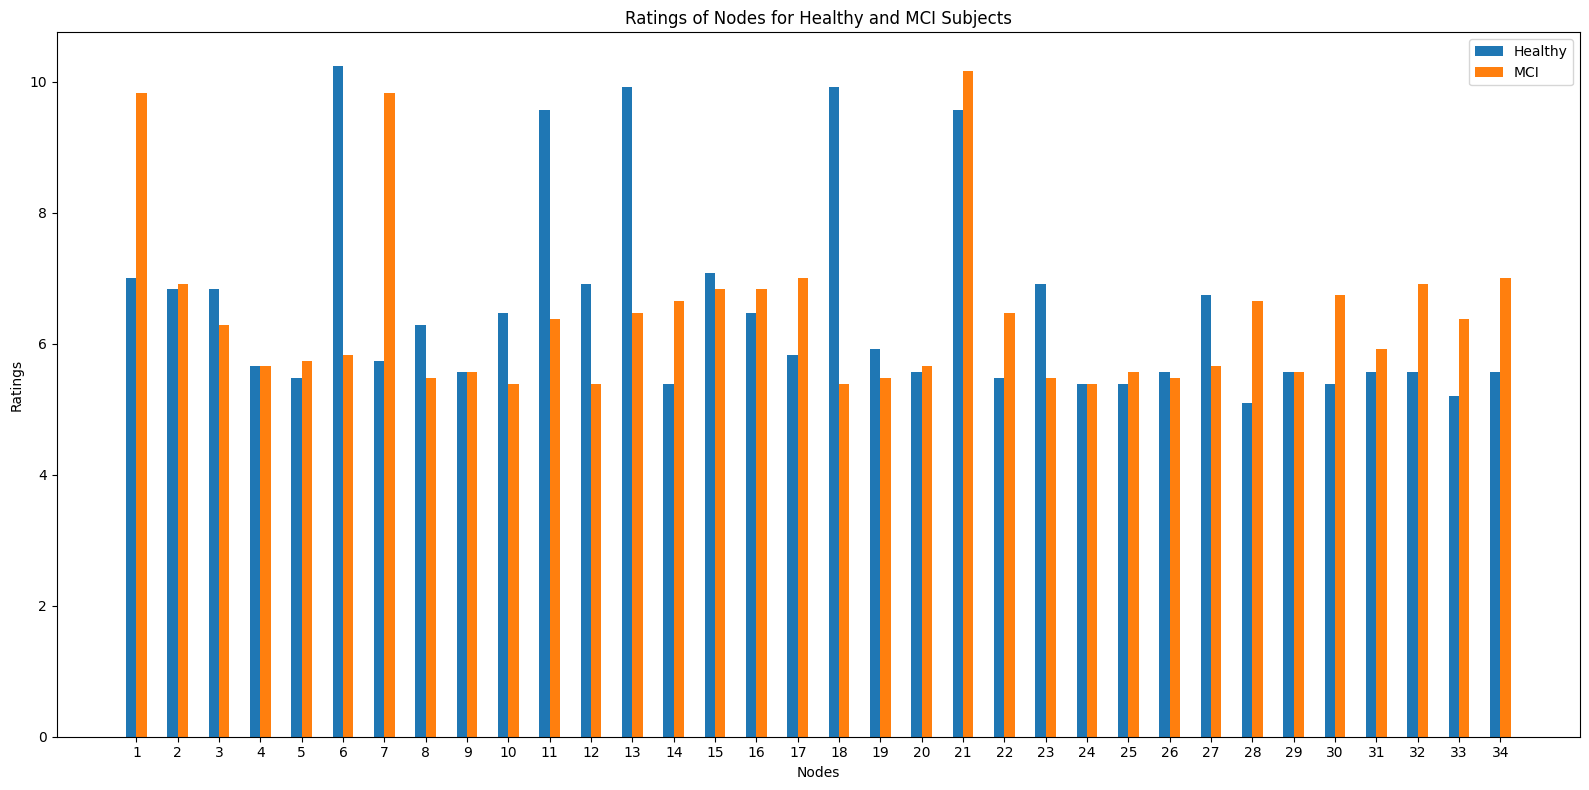

In [53]:
import matplotlib.pyplot as plt

# Node labels for the x-axis
node_labels = [f"{i+1}" for i in range(34)]

# Ratings for healthy and MCI subjects
ratings_healthy = [ratings_healthy[i] for i in range(34)]
ratings_mci = [ratings_mci[i] for i in range(34)]

# Set the width of the bars
bar_width = 0.25

# Set the positions of the bars on the x-axis
index = range(len(node_labels))

# Create a figure with a larger size
fig, ax = plt.subplots(figsize=(16, 8))  # Adjust the size as needed

# Plot the ratings for healthy subjects
rects1 = ax.bar(index, ratings_healthy, bar_width, label='Healthy')

# Plot the ratings for MCI subjects
rects2 = ax.bar([i + bar_width for i in index], ratings_mci, bar_width, label='MCI')

# Add labels, title, and legend
ax.set_xlabel('Nodes')
ax.set_ylabel('Ratings')
ax.set_title('Ratings of Nodes for Healthy and MCI Subjects')
ax.set_xticks([i + bar_width/2 for i in index])
ax.set_xticklabels(node_labels)
ax.legend()

# Save the plot as an image
plt.tight_layout()
plt.savefig('ratings_plot.png')

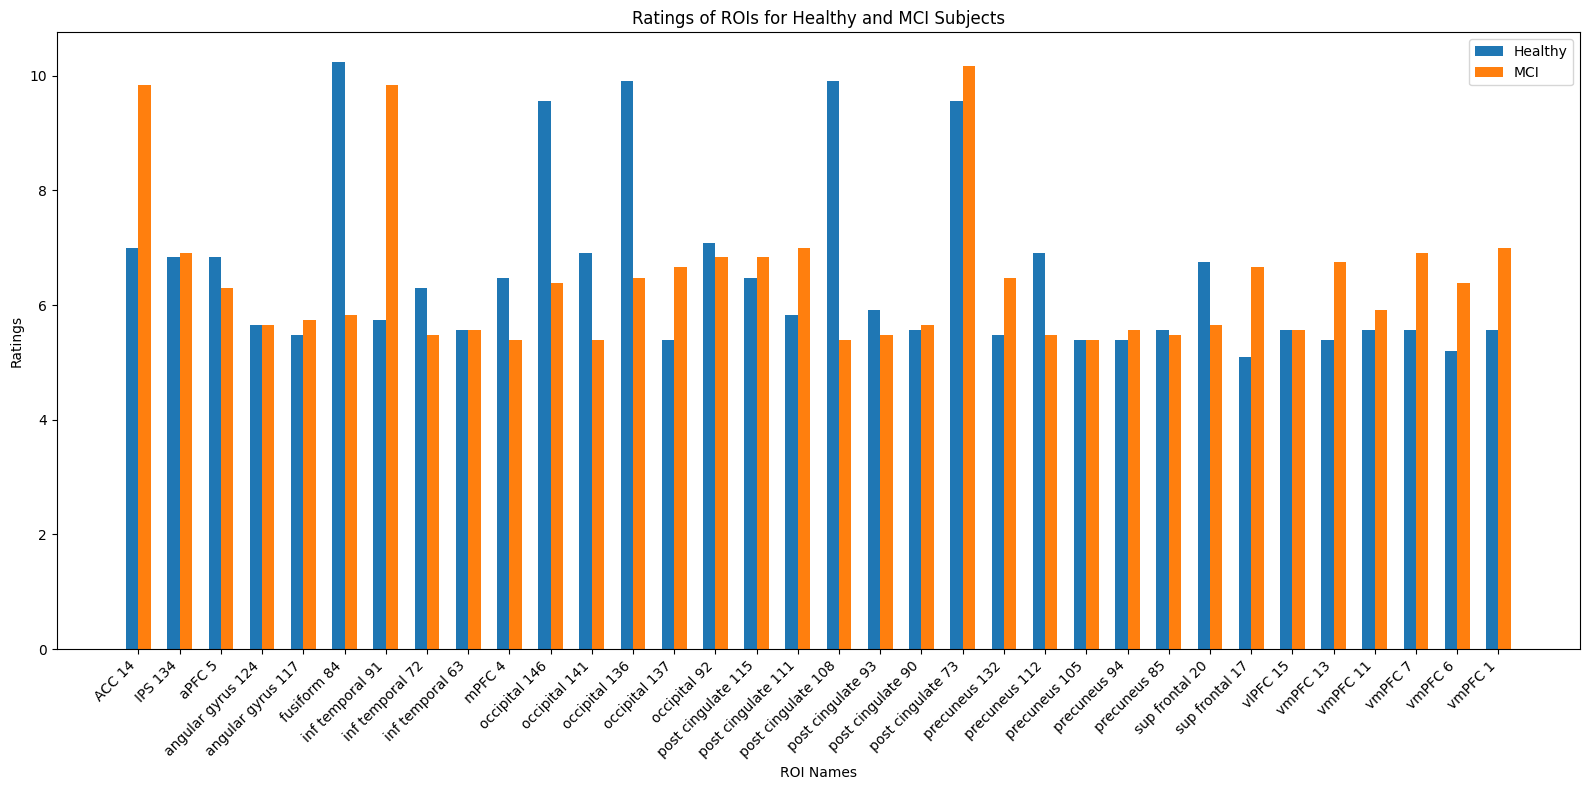

In [54]:
import matplotlib.pyplot as plt

# ROI names for the x-axis
roi_names = [
    "ACC 14", "IPS 134", "aPFC 5", "angular gyrus 124", "angular gyrus 117",
    "fusiform 84", "inf temporal 91", "inf temporal 72", "inf temporal 63",
    "mPFC 4", "occipital 146", "occipital 141", "occipital 136", "occipital 137",
    "occipital 92", "post cingulate 115", "post cingulate 111", "post cingulate 108",
    "post cingulate 93", "post cingulate 90", "post cingulate 73", "precuneus 132",
    "precuneus 112", "precuneus 105", "precuneus 94", "precuneus 85",
    "sup frontal 20", "sup frontal 17", "vlPFC 15", "vmPFC 13", "vmPFC 11",
    "vmPFC 7", "vmPFC 6", "vmPFC 1"
]

# Ratings for healthy and MCI subjects
ratings_healthy = [ratings_healthy[i] for i in range(34)]
ratings_mci = [ratings_mci[i] for i in range(34)]

# Set the width of the bars
bar_width = 0.3

# Set the positions of the bars on the x-axis
index = range(len(roi_names))

# Create a figure with a larger size
fig, ax = plt.subplots(figsize=(16, 8))  # Adjust the size as needed

# Plot the ratings for healthy subjects
rects1 = ax.bar(index, ratings_healthy, bar_width, label='Healthy')

# Plot the ratings for MCI subjects
rects2 = ax.bar([i + bar_width for i in index], ratings_mci, bar_width, label='MCI')

# Add labels, title, and legend
ax.set_xlabel('ROI Names')
ax.set_ylabel('Ratings')
ax.set_title('Ratings of ROIs for Healthy and MCI Subjects')
ax.set_xticks([i + bar_width/2 for i in index])
ax.set_xticklabels(roi_names, rotation=45, ha='right')  # Rotate the labels for a slanted display
ax.legend()

# Save the plot as an image
plt.tight_layout()
plt.savefig('Named_ratings_plot.png')

# Quantifying Differences

In [55]:
# # Calculate the absolute percentage difference in ratings for each node
# absolute_percentage_differences = []
# for node in range(34):
#     healthy_rating = ratings_healthy[node]
#     mci_rating = ratings_mci[node]

#     if healthy_rating == 0 and mci_rating == 0:
#         percentage_difference = 0
#     else:
#         percentage_difference = abs(healthy_rating - mci_rating) / max(healthy_rating, mci_rating) * 100

#     absolute_percentage_differences.append((node, percentage_difference))

# # Sort the nodes by absolute percentage difference in descending order
# sorted_absolute_percentage_differences = sorted(absolute_percentage_differences, key=lambda x: x[1], reverse=True)

# # Print the nodes and their absolute percentage differences
# for node, percentage_difference in sorted_absolute_percentage_differences:
#     print(f"Node {node}: Absolute Percentage Difference = {percentage_difference:.2f}%")

In [56]:
# Calculate the absolute percentage difference in ratings for each node
absolute_percentage_differences = []
for node in range(34):
    healthy_rating = ratings_healthy[node]
    mci_rating = ratings_mci[node]

    if healthy_rating == 0 and mci_rating == 0:
        percentage_difference = 0
    else:
        percentage_difference = abs(healthy_rating - mci_rating) / max(healthy_rating, mci_rating) * 100

    # Determine which class has a higher rating
    higher_class = "Healthy" if healthy_rating > mci_rating else "MCI"

    absolute_percentage_differences.append((node, percentage_difference, higher_class))

# Sort the nodes by absolute percentage difference in descending order
sorted_absolute_percentage_differences = sorted(absolute_percentage_differences, key=lambda x: x[1], reverse=True)

# Print the nodes, their absolute percentage differences, and which class has a higher rating
for node, percentage_difference, higher_class in sorted_absolute_percentage_differences:
    print(f"Node {node}: Absolute Percentage Difference = {percentage_difference:.2f}% (Higher Class: {higher_class})")

Node 17: Absolute Percentage Difference = 45.69% (Higher Class: Healthy)
Node 5: Absolute Percentage Difference = 43.08% (Higher Class: Healthy)
Node 6: Absolute Percentage Difference = 41.57% (Higher Class: MCI)
Node 12: Absolute Percentage Difference = 34.68% (Higher Class: Healthy)
Node 10: Absolute Percentage Difference = 33.26% (Higher Class: Healthy)
Node 0: Absolute Percentage Difference = 28.80% (Higher Class: MCI)
Node 27: Absolute Percentage Difference = 23.40% (Higher Class: MCI)
Node 11: Absolute Percentage Difference = 22.14% (Higher Class: Healthy)
Node 22: Absolute Percentage Difference = 20.80% (Higher Class: Healthy)
Node 33: Absolute Percentage Difference = 20.46% (Higher Class: MCI)
Node 29: Absolute Percentage Difference = 20.16% (Higher Class: MCI)
Node 31: Absolute Percentage Difference = 19.50% (Higher Class: MCI)
Node 13: Absolute Percentage Difference = 19.10% (Higher Class: MCI)
Node 32: Absolute Percentage Difference = 18.62% (Higher Class: MCI)
Node 9: Absol

In [57]:
# Define a dictionary to map node numbers to ROI names
node_roi_mapping = {
    1: "ACC 14",
    2: "IPS 134",
    3: "aPFC 5",
    4: "angular gyrus 124",
    5: "angular gyrus 117",
    6: "fusiform 84",
    7: "inf temporal 91",
    8: "inf temporal 72",
    9: "inf temporal 63",
    10: "mPFC 4",
    11: "occipital 146",
    12: "occipital 141",
    13: "occipital 136",
    14: "occipital 137",
    15: "occipital 92",
    16: "post cingulate 115",
    17: "post cingulate 111",
    18: "post cingulate 108",
    19: "post cingulate 93",
    20: "post cingulate 90",
    21: "post cingulate 73",
    22: "precuneus 132",
    23: "precuneus 112",
    24: "precuneus 105",
    25: "precuneus 94",
    26: "precuneus 85",
    27: "sup frontal 20",
    28: "sup frontal 17",
    29: "vlPFC 15",
    30: "vmPFC 13",
    31: "vmPFC 11",
    32: "vmPFC 7",
    33: "vmPFC 6",
    34: "vmPFC 1",
}

# Calculate the absolute percentage difference in ratings for each node
absolute_percentage_differences = []
for node in range(1, 35):  # Node numbers from 1 to 34
    healthy_rating = ratings_healthy[node - 1]  # Subtract 1 to match Python indexing
    mci_rating = ratings_mci[node - 1]

    if healthy_rating == 0 and mci_rating == 0:
        percentage_difference = 0
    else:
        percentage_difference = abs(healthy_rating - mci_rating) / max(healthy_rating, mci_rating) * 100

    # Determine which class has a higher rating
    higher_class = "Healthy" if healthy_rating > mci_rating else "MCI"

    # Get the ROI name for the node number
    roi_name = node_roi_mapping.get(node, "Unknown ROI")

    absolute_percentage_differences.append((node, roi_name, percentage_difference, higher_class))

# Sort the nodes by absolute percentage difference in descending order
sorted_absolute_percentage_differences = sorted(absolute_percentage_differences, key=lambda x: x[2], reverse=True)

# Print the nodes, their ROI names, absolute percentage differences, and which class has a higher rating
for node, roi_name, percentage_difference, higher_class in sorted_absolute_percentage_differences:
    print(f"Node {node} ({roi_name}): Absolute Percentage Difference = {percentage_difference:.2f}% (Higher Class: {higher_class})")

Node 18 (post cingulate 108): Absolute Percentage Difference = 45.69% (Higher Class: Healthy)
Node 6 (fusiform 84): Absolute Percentage Difference = 43.08% (Higher Class: Healthy)
Node 7 (inf temporal 91): Absolute Percentage Difference = 41.57% (Higher Class: MCI)
Node 13 (occipital 136): Absolute Percentage Difference = 34.68% (Higher Class: Healthy)
Node 11 (occipital 146): Absolute Percentage Difference = 33.26% (Higher Class: Healthy)
Node 1 (ACC 14): Absolute Percentage Difference = 28.80% (Higher Class: MCI)
Node 28 (sup frontal 17): Absolute Percentage Difference = 23.40% (Higher Class: MCI)
Node 12 (occipital 141): Absolute Percentage Difference = 22.14% (Higher Class: Healthy)
Node 23 (precuneus 112): Absolute Percentage Difference = 20.80% (Higher Class: Healthy)
Node 34 (vmPFC 1): Absolute Percentage Difference = 20.46% (Higher Class: MCI)
Node 30 (vmPFC 13): Absolute Percentage Difference = 20.16% (Higher Class: MCI)
Node 32 (vmPFC 7): Absolute Percentage Difference = 19.5

In [58]:
import pandas as pd

# Create an unsorted DataFrame
unsorted_df = pd.DataFrame(sorted_absolute_percentage_differences, columns=["Node Number", "ROI Name", "Percentage Difference", "Higher Class"])

# Create a sorted DataFrame by absolute percentage difference in descending order
sorted_df = unsorted_df.sort_values(by="Node Number", ascending=True)

# Print the sorted DataFrame
print(sorted_df)
print("\n")
# Print the unsorted DataFrame
print(unsorted_df)


sorted_df.to_csv("SI_NodeNumber_ordered.csv", index = False)
unsorted_df.to_csv("SI_Percent_ordered.csv", index = False)

    Node Number            ROI Name  Percentage Difference Higher Class
5             1              ACC 14              28.796315          MCI
29            2             IPS 134               1.230869          MCI
19            3              aPFC 5               7.897132      Healthy
30            4   angular gyrus 124               0.000000          MCI
24            5   angular gyrus 117               4.653741          MCI
1             6         fusiform 84              43.084890      Healthy
2             7     inf temporal 91              41.566567          MCI
18            8     inf temporal 72              12.942489      Healthy
31            9     inf temporal 63               0.000000          MCI
14           10              mPFC 4              16.860008      Healthy
4            11       occipital 146              33.263774      Healthy
7            12       occipital 141              22.135589      Healthy
3            13       occipital 136              34.679574      